# 🥱 LangChain 與 LangGraph 串流技術深度探索

在這個教程中，我們將深入探討 LangChain 和 LangGraph 的串流（Streaming）功能，這對於打造反應靈敏的 AI 應用至關重要。本指南假設您已熟悉以下概念：

- 聊天模型（Chat models）
- LangChain 表達語言（LangChain Expression Language）
- 輸出解析器（Output parsers）

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).


# 為什麼串流如此重要？

在基於大型語言模型（LLM）的應用中，串流技術扮演著舉足輕重的角色。它能夠顯著提升用戶體驗，讓應用感覺更加靈敏和即時。

LangChain 中的核心元素，如聊天模型、輸出解析器、提示模板、檢索器和代理等，都實現了 LangChain 可運行接口（Runnable Interface）。這個接口提供了兩種主要的串流方法：

1. `sync stream` 和 `async astream`：這是默認的串流實現，用於串流鏈條的最終輸出。
2. async `astream_events` 和 async `astream_log`：這些方法能夠串流中間步驟和最終輸出。


[相關文件:LangChain/How-to-Guides/How to stream runnables](https://python.langchain.com/v0.2/docs/how_to/streaming/)

接下來，我們將深入探討這兩種方法，並學習如何靈活運用它們。


> [技術亮點] LangChain 的串流功能不僅提高了應用的響應速度，還能讓開發者更靈活地處理和展示 AI 生成的內容。

# 環境建置

在開始我們的探索之前，讓我們先搭建實驗環境。

## 安裝套件包

在深入之前，我們需要先搭建實驗環境。

以下是所需的套件安裝命令：

In [ ]:
%%capture --no-stderr
%pip install --quiet langchain
%pip install --quiet langchain-openai

In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

📌 實用提示：確保所有環境變數都正確設置，這對於順利運行後續程式碼至關重要。

# 深入了解 Chat Model 的互動機制

為了簡化自定義鏈的創建過程，LangChain 實現了一個"可運行"（Runnable）協議。許多 LangChain 組件都實現了這個協議，包括聊天模型、LLM、輸出解析器、檢索器、提示模板等。

這個標準接口使得定義和調用自定義鏈變得簡單直接。主要包括以下方法：

- `stream`：串流回應的片段
- `invoke`：對輸入調用鏈
- `batch`：對輸入列表調用鏈

所有的 Runnable 物件都實作了一個同步方法 `stream` 和一個異步變體 `astream`。

這些方法旨在以分塊(Chunk)形式串流最終輸出，並在每個塊可用時立即生成。

[相關文件：LangChain Runnable interface](https://python.langchain.com/v0.1/docs/expression_language/interface/)

## 同步調用：invoke 方法解析

`invoke()` 方法是最直接的使用方式，會在模型生成完整回應後才返回完整結果。讓我們看一個實際例子：

In [ ]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI()

model.invoke("請你講一個早安問候語")

AIMessage(content='早安，願你今天充滿活力與快樂！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 25, 'total_tokens': 48}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-93754cf7-50b4-4a99-b2d0-0fcdd42f620e-0', usage_metadata={'input_tokens': 25, 'output_tokens': 23, 'total_tokens': 48})

> [技術說明] invoke() 方法適用於對實時性要求不高的場景，或當您需要一次性獲取完整回應時使用。

## Stream 方法的魅力

相比之下，stream() 方法允許我們在生成過程中逐步獲取回應，這對提升用戶體驗至關重要。`stream()` 方法返回一個生成器，能夠在生成過程中逐步產生 token。

串流處理的實現需要程序中的每個步驟都能夠處理輸入流。這意味著每個組件都要能夠一次處理一個輸入塊，並生成相應的輸出塊。這種處理方式帶來了獨特的優勢和挑戰：

1. 連續性處理：串流允許系統在接收到完整輸入之前就開始處理和輸出，大大提高了響應速度和效率。
2. 複雜度變化：串流處理的複雜度可能差異很大：
 - 簡單任務：如直接輸出 LLM 生成的 token。
 - 複雜任務：如在 JSON 結果完全生成之前就開始串流其部分內容。
3. 靈活性與挑戰：這種方法提供了極大的靈活性，但也帶來了編程上的挑戰，特別是在處理結構化數據或需要整體上下文的任務時。
4. 最佳起點：要開始探索串流技術，最好的切入點就是 LLM 應用中最核心的組件——LLM 本身。這是因為 LLM 天生就適合token級別的串流輸出。

> [技術要點] 串流的關鍵在於程序中的每個步驟都能夠處理輸入流，即一次處理一個輸入塊，並生成相應的輸出塊。它要求開發者重新思考數據處理流程，從整體處理轉向增量處理。

In [ ]:
print(model.invoke("請你講一個早安問候語"))

content='早安！祝你今天充滿活力和快樂！' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 25, 'total_tokens': 47}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-2d823c99-fe70-4a48-b532-eed8e18ef391-0' usage_metadata={'input_tokens': 25, 'output_tokens': 22, 'total_tokens': 47}


In [ ]:
print(model.stream("請你講一個早安問候語"))

<generator object BaseChatModel.stream at 0x7b5bdde0cba0>


如果您在異步環境中工作，可以考慮使用異步的 `astream` API：

In [ ]:
chunks = []
async for chunk in model.astream("請你告訴我 k8s 跟 docker 區別"):
    chunks.append(chunk)
    print(chunk.content, end="|", flush=True)

|K|ubernetes|（|簡|稱| k|8|s|）|和| Docker| 是|兩|個|不|同|的|容|器|技|術|。

|D|ocker| 是|一|個|開|源|的|容|器|化|平|台|，|可以|將|應|用|程序|和|其|相|關|的|依|賴|項|打|包|成|一|個|獨|立|的|容|器|，|使|其|可以|在|任|何|環|境|中|運|行|。|D|ocker| 提|供|了|一|個|輕|量|級|的|容|器|化|解|決|方|案|，|使|開|發|人|員|可以|更|容|易|地|部|署|和|管理|應|用|程序|。

|K|ubernetes| 是|一|個|開|源|的|容|器|管理|平|台|，|用|於|自|動|化|部|署|、|擴|展|和|管理|容|器|化|應|用|程序|。|K|ubernetes| 可|以|管理|多|個| Docker| 容|器|，|並|提|供|了|許|多|功能|，|如|自|動|擴|展|、|負|載|均|衡|、|服|務|發|現|等|，|使|容|器|化|應|用|程序|更|容|易|在|生|產|環|境|中|運|行|。

|總|的|來|說|，|D|ocker| 是|一|個|容|器|化|平|台|，|而| Kubernetes| 是|一|個|容|器|管理|平|台|，|它|們|可以|一|起|使用|，|但|各|自|擁|有|不|同|的|功能|和|用|途|。||

> [實用技巧] 使用 end="|" 和 flush=True 可以實現平滑的輸出效果，讓用戶感受到實時生成的過程。

In [ ]:
chunks[1]

AIMessageChunk(content='K', id='run-d78fce95-17a8-4d0f-aeb4-2c9be1e950e8')

In [ ]:
chunks[2]

AIMessageChunk(content='ubernetes', id='run-d78fce95-17a8-4d0f-aeb4-2c9be1e950e8')

In [ ]:
chunks[1] + chunks[2]

AIMessageChunk(content='Kubernetes', id='run-d78fce95-17a8-4d0f-aeb4-2c9be1e950e8')

> [注意] 我們得到的是 `AIMessageChunk` 對象。這些塊在設計上是可累加的——只需簡單地將它們相加，就能得到到目前為止的完整響應狀態！

In [ ]:
for chunk in model.stream("寫一首關於 k8s 的兒歌"):
    print(chunk.content, end="", flush=True)

K8s 是個神奇的軟體，
讓我們的應用更加完美。
它像個小管家，
幫助我們管理容器。

K8s，K8s，快來幫我們，
讓我們的應用更加強大。
K8s，K8s，我們愛你，
讓我們的系統更加穩定。

K8s像一位巫師，
讓我們的應用飛速運行。
它就像一座城堡，
保護著我們的程式碼。

K8s，K8s，你是最棒的，
讓我們的應用更加完美。
K8s，K8s，我們感謝你，
讓我們的系統更加順暢。

# 結合 LangChain 表達語言（LCEL）實現持續串流回應

現在，讓我們將 Prompt、Model 和 OutputParser 結合起來，驗證串流效果。

> [技術焦點] 我們將使用 StrOutputParser 來解析模型的輸出。這是一個簡單的解析器，它從 AIMessageChunk 中提取內容字段，給我們模型返回的 token。

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template("講一個早安問候語關於 {topic}")
parser = StrOutputParser()
chain = prompt | model | parser

async for chunk in chain.astream({"topic": "父母親"}):
    print(chunk, end="|", flush=True)

|早|安|！|父|母|親|，|感|謝|您|們|無|私|的|愛|與|付|出|，|願|您|們|今|天|充|滿|幸|福|與|快|樂|！||

> [提示] LCEL 是一種聲明式方法，用於通過鏈接不同的 LangChain 原語來指定"程序"。使用 LCEL 創建的鏈條會自動實現 stream 和 astream，允許串流最終輸出。

> StrOutputParser 用途就是把 Chunk 當中 content 提出==

# 探索 `Stream_Events` 高級串流技術

Event Streaming 是一個 beta API，可能會根據反饋進行調整。本指南演示的是 V2 API，需要 langchain-core >= 0.2 版本。如果要使用 V1 API 的話需要參考[舊版 LangChain 官方文件](https://python.langchain.com/v0.1/docs/expression_language/streaming/#using-stream-events)

[langChain v0.2 Concepts/Streaming 文件連結](https://python.langchain.com/v0.2/docs/concepts/#streaming)


[版本提醒] 確保您使用的是最新版本的 LangChain：

In [ ]:
import langchain_core

langchain_core.__version__

'0.2.33'



為了讓 `astream_events` API 正常工作，請注意以下幾點：

- 盡可能在整個代碼中使用 `async`（例如，異步工具等）
- 在定義自定義函數/ runnalbes 時傳播 callbacks
- 當不使用 LCEL 而使用可運行對象時，確保調用 LLM 的 `.astream()` 而不是 `.ainvoke`，以強制 LLM 串流 token


## Stream_Events 事件參考指南

以下是各種 Runnable 物件 可能發出的一些事件的參考表：


| event                | name             | chunk                           | input                                         | output                                          |
|----------------------|------------------|---------------------------------|-----------------------------------------------|-------------------------------------------------|
| on_chat_model_start  | [model name]     |                                 | {"messages": [[SystemMessage, HumanMessage]]} |                                                 |
| on_chat_model_stream | [model name]     | AIMessageChunk(content="hello") |                                               |                                                 |
| on_chat_model_end    | [model name]     |                                 | {"messages": [[SystemMessage, HumanMessage]]} | AIMessageChunk(content="hello world")           |
| on_llm_start         | [model name]     |                                 | {'input': 'hello'}                            |                                                 |
| on_llm_stream        | [model name]     | 'Hello'                         |                                               |                                                 |
| on_llm_end           | [model name]     |                                 | 'Hello human!'                                |                                                 |
| on_chain_start       | format_docs      |                                 |                                               |                                                 |
| on_chain_stream      | format_docs      | "hello world!, goodbye world!"  |                                               |                                                 |
| on_chain_end         | format_docs      |                                 | [Document(...)]                               | "hello world!, goodbye world!"                  |
| on_tool_start        | some_tool        |                                 | {"x": 1, "y": "2"}                            |                                                 |
| on_tool_end          | some_tool        |                                 |                                               | {"x": 1, "y": "2"}                              |
| on_retriever_start   | [retriever name] |                                 | {"query": "hello"}                            |                                                 |
| on_retriever_end     | [retriever name] |                                 | {"query": "hello"}                            | [Document(...), ..]                             |
| on_prompt_start      | [template_name]  |                                 | {"question": "hello"}                         |                                                 |
| on_prompt_end        | [template_name]  |                                 | {"question": "hello"}                         | ChatPromptValue(messages: [SystemMessage, ...]) |


> [注意] 當串流正確實現時，可運行對象的輸入直到輸入流完全消耗後才能知道。這意味著輸入通常只包含在結束事件中，而不是開始事件中。

## 從 Chat Model(聊天模型) 了解運作機制

讓我們來看看聊天模型產生的事件：


In [ ]:
events = []
async for event in model.astream_events("早安", version="v2"):
    events.append(event)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


讓我們看看前幾個事件和最後幾個事件。

In [ ]:
import rich
rich.print(events[:3])

[
    {
        'event': 'on_chat_model_start',
        'data': {'input': '早安'},
        'name': 'ChatOpenAI',
        'tags': [],
        'run_id': '2cdfdc79-1ec3-4682-9240-6faad3c2a9c5',
        'metadata': {
            'ls_provider': 'openai',
            'ls_model_name': 'gpt-3.5-turbo',
            'ls_model_type': 'chat',
            'ls_temperature': 0.7
        },
        'parent_ids': []
    },
    {
        'event': 'on_chat_model_stream',
        'run_id': '2cdfdc79-1ec3-4682-9240-6faad3c2a9c5',
        'name': 'ChatOpenAI',
        'tags': [],
        'metadata': {
            'ls_provider': 'openai',
            'ls_model_name': 'gpt-3.5-turbo',
            'ls_model_type': 'chat',
            'ls_temperature': 0.7
        },
        'data': {'chunk': AIMessageChunk(content='', id='run-2cdfdc79-1ec3-4682-9240-6faad3c2a9c5')},
        'parent_ids': []
    },
    {
        'event': 'on_chat_model_stream',
        'run_id': '2cdfdc79-1ec3-4682-9240-6faad3c2a9c5',
        'name': 'ChatOpenAI',
        'tags': [],
        'metadata': {
            'ls_provider': 'openai',
            'ls_model_name': 'gpt-3.5-turbo',
            'ls_model_type': 'chat',
            'ls_temperature': 0.7
        },
        'data': {'chunk': AIMessageChunk(content='早', id='run-2cdfdc79-1ec3-4682-9240-6faad3c2a9c5')},
        'parent_ids': []
    }
]

In [ ]:
rich.print(events[-2:])

[
    {
        'event': 'on_chat_model_stream',
        'run_id': '2cdfdc79-1ec3-4682-9240-6faad3c2a9c5',
        'name': 'ChatOpenAI',
        'tags': [],
        'metadata': {
            'ls_provider': 'openai',
            'ls_model_name': 'gpt-3.5-turbo',
            'ls_model_type': 'chat',
            'ls_temperature': 0.7
        },
        'data': {
            'chunk': AIMessageChunk(
                content='',
                response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'},
                id='run-2cdfdc79-1ec3-4682-9240-6faad3c2a9c5'
            )
        },
        'parent_ids': []
    },
    {
        'event': 'on_chat_model_end',
        'data': {
            'output': AIMessageChunk(
                content='早安！祝您有美好的一天。',
                response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'},
                id='run-2cdfdc79-1ec3-4682-9240-6faad3c2a9c5'
            )
        },
        'run_id': '2cdfdc79-1ec3-4682-9240-6faad3c2a9c5',
        'name': 'ChatOpenAI',
        'tags': [],
        'metadata': {
            'ls_provider': 'openai',
            'ls_model_name': 'gpt-3.5-turbo',
            'ls_model_type': 'chat',
            'ls_temperature': 0.7
        },
        'parent_ids': []
    }
]

In [ ]:
event_types = {event["event"] for event in events}
print("拉出存在的 event types:", event_types)

可以注意到回傳 Message 當中不同 Chunk 所在的 event 是不同的，從一開始 `on_chat_model_start`, `on_chat_model_stream`, 到最後 `on_chat_model_end`

整理一下輸出好方便識別


In [ ]:
async for event in model.astream_events("早安", version="v2"):
    event_type = event["event"]
    if event_type =="on_chat_model_start":
        print("Streamgin Start", flush=False)
    if event_type == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
          # 要考慮一下回傳沒有的情況
          print(content, end="|", flush=False)
    if event_type == "on_chat_model_end":
        print("\nStreamgin End", flush=False)

Streamgin Start
早|安|！|祝|您|今|天|过|得|愉|快|！|
Streamgin End


## 結合 Parser 處理串流輸出格式

讓我們重新審視使用串流輸出解析器的鏈條示例，探索串流事件 API：

In [ ]:
prompt = ChatPromptTemplate.from_template("講一個早安問候語關於 {topic}")
parser = StrOutputParser()
chain = prompt | model | parser

parser_events = []
async for event in chain.astream_events({"topic": "父母親"}, version="v2"):
    parser_events.append(event)

If you examine at the first few events, you'll notice that there are 3 different start events rather than 2 start events.

The three start events correspond to:

1. The chain (model + parser)
2. The model
3. The parser

讓我們來觀察前六比事件。

In [ ]:
rich.print(parser_events[:6])

[
    {
        'event': 'on_chain_start',
        'data': {'input': {'topic': '父母親'}},
        'name': 'RunnableSequence',
        'tags': [],
        'run_id': 'a09e4434-073d-402b-a9d2-e1d25c7c07d3',
        'metadata': {},
        'parent_ids': []
    },
    {
        'event': 'on_prompt_start',
        'data': {'input': {'topic': '父母親'}},
        'name': 'ChatPromptTemplate',
        'tags': ['seq:step:1'],
        'run_id': '4d16c3de-b120-4da2-9641-fc6e5cd18da8',
        'metadata': {},
        'parent_ids': ['a09e4434-073d-402b-a9d2-e1d25c7c07d3']
    },
    {
        'event': 'on_prompt_end',
        'data': {
            'output': ChatPromptValue(messages=[HumanMessage(content='講一個早安問候語關於 父母親')]),
            'input': {'topic': '父母親'}
        },
        'run_id': '4d16c3de-b120-4da2-9641-fc6e5cd18da8',
        'name': 'ChatPromptTemplate',
        'tags': ['seq:step:1'],
        'metadata': {},
        'parent_ids': ['a09e4434-073d-402b-a9d2-e1d25c7c07d3']
    },
    {
        'event': 'on_chat_model_start',
        'data': {'input': {'messages': [[HumanMessage(content='講一個早安問候語關於 父母親')]]}},
        'name': 'ChatOpenAI',
        'tags': ['seq:step:2'],
        'run_id': 'd34c2887-eb15-4d62-b036-cace575d8906',
        'metadata': {
            'ls_provider': 'openai',
            'ls_model_name': 'gpt-3.5-turbo',
            'ls_model_type': 'chat',
            'ls_temperature': 0.7
        },
        'parent_ids': ['a09e4434-073d-402b-a9d2-e1d25c7c07d3']
    },
    {
        'event': 'on_chat_model_stream',
        'data': {'chunk': AIMessageChunk(content='', id='run-d34c2887-eb15-4d62-b036-cace575d8906')},
        'run_id': 'd34c2887-eb15-4d62-b036-cace575d8906',
        'name': 'ChatOpenAI',
        'tags': ['seq:step:2'],
        'metadata': {
            'ls_provider': 'openai',
            'ls_model_name': 'gpt-3.5-turbo',
            'ls_model_type': 'chat',
            'ls_temperature': 0.7
        },
        'parent_ids': ['a09e4434-073d-402b-a9d2-e1d25c7c07d3']
    },
    {
        'event': 'on_parser_start',
        'data': {},
        'name': 'StrOutputParser',
        'tags': ['seq:step:3'],
        'run_id': '827de03d-5d20-4d6a-a6f2-b3455a873859',
        'metadata': {},
        'parent_ids': ['a09e4434-073d-402b-a9d2-e1d25c7c07d3']
    }
]

當我們仔細檢視事件流的開始部分時，會發現一個有趣的現象：出現了三個不同的開始事件，而不是預期的兩個。這三個開始事件分別對應於：

1. 整個鏈條（模型 + 解析器）的啟動 `on_chain_start`
2. 模型的初始化
3. 解析器的準備階段 `on_prompt_start`

這種層次化的事件結構反映了整個處理流程的組織方式，讓我們能夠精確地追蹤每個組件的運作狀態。

讓我們通過實際操作來探索這個 API，特別關注模型和解析器的串流事件。為了聚焦於核心過程，我們將忽略開始事件、結束事件以及整個鏈條的事件。

In [ ]:
num_events = 0

async for event in chain.astream_events(
    {"topic": "父母親"},
    version="v2",
):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        print(
            f"模型輸出 chunk: {repr(event['data']['chunk'].content)}",
            flush=True,
        )
    if kind == "on_parser_stream":
        print(f"解析器輸出 chunk: {event['data']['chunk']}", flush=True)
    num_events += 1
    if num_events > 30:
        # Truncate the output
        print("...")
        break

Chat model chunk: ''
Parser chunk: 
Chat model chunk: '早'
Parser chunk: 早
Chat model chunk: '安'
Parser chunk: 安
Chat model chunk: '，'
Parser chunk: ，
Chat model chunk: '親'
Parser chunk: 親
Chat model chunk: '愛'
Parser chunk: 愛
Chat model chunk: '的'
Parser chunk: 的
Chat model chunk: '爸'
Parser chunk: 爸
Chat model chunk: '媽'
Parser chunk: 媽
...


[技術洞察]

1. 事件分層：這種分層結構使我們能夠分別監控和分析鏈條、模型和解析器的行為。
2. 實時追蹤：通過觀察 "on_chat_model_stream" 和 "on_parser_stream" 事件，我們可以實時跟蹤生成過程和解析過程。
3. 性能優化機會：這種細粒度的事件流為性能分析和優化提供了寶貴的數據源。

## 事件過濾技巧


由於這個 API 產生了大量事件，能夠過濾事件變得非常有用。你可以按組件 `name`、組件 `tags` 或組件 `type` 進行過濾。

### 按類型(type)過濾

In [ ]:
max_events = 0
async for event in chain.astream_events(
    {"topic": "父母親"},
    version="v2",
    include_types=["chat_model"],
):
    print(event)
    max_events += 1
    if max_events > 10:
        # Truncate output
        print("...")
        break

{'event': 'on_chat_model_start', 'data': {'input': {'topic': '父母親'}}, 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'run_id': 'f3aec1d4-3d28-4947-be79-a7c9b61bca8b', 'metadata': {'ls_provider': 'openai', 'ls_model_name': 'gpt-3.5-turbo', 'ls_model_type': 'chat', 'ls_temperature': 0.7}, 'parent_ids': ['a5a69b8c-3b5f-453e-ac1f-8fabe0603edc']}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', id='run-f3aec1d4-3d28-4947-be79-a7c9b61bca8b')}, 'run_id': 'f3aec1d4-3d28-4947-be79-a7c9b61bca8b', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'ls_provider': 'openai', 'ls_model_name': 'gpt-3.5-turbo', 'ls_model_type': 'chat', 'ls_temperature': 0.7}, 'parent_ids': ['a5a69b8c-3b5f-453e-ac1f-8fabe0603edc']}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='早', id='run-f3aec1d4-3d28-4947-be79-a7c9b61bca8b')}, 'run_id': 'f3aec1d4-3d28-4947-be79-a7c9b61bca8b', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'ls_provider': 'op

> [提示] 注意事件名稱通常是 `on_XXX_[start/stream/end]` 這樣的格式，但在示例中只寫了 chat_model。這是因為內部過濾器會提取 XXX 部分。


讓我們嘗試一次擷取多個類型：

In [ ]:
max_events = 0
async for event in chain.astream_events(
    {"topic": "父母親"},
    version="v2",
    include_types=["chat_model", "prompt"],
):
    print(event)
    max_events += 1
    if max_events > 10:
        # Truncate output
        print("...")
        break

{'event': 'on_prompt_start', 'data': {'input': {'topic': '父母親'}}, 'name': 'ChatPromptTemplate', 'tags': ['seq:step:1'], 'run_id': '04af2458-f973-446c-88a4-a0bf61187aa0', 'metadata': {}, 'parent_ids': ['aa8e7717-51a9-49d6-82e2-795e63063810']}
{'event': 'on_prompt_end', 'data': {'output': ChatPromptValue(messages=[HumanMessage(content='講一個早安問候語關於 父母親')])}, 'run_id': '04af2458-f973-446c-88a4-a0bf61187aa0', 'name': 'ChatPromptTemplate', 'tags': ['seq:step:1'], 'metadata': {}, 'parent_ids': ['aa8e7717-51a9-49d6-82e2-795e63063810']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='講一個早安問候語關於 父母親')]]}}, 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'run_id': 'c85f138c-93fb-46be-8b2e-de02dba65160', 'metadata': {'ls_provider': 'openai', 'ls_model_name': 'gpt-3.5-turbo', 'ls_model_type': 'chat', 'ls_temperature': 0.7}, 'parent_ids': ['aa8e7717-51a9-49d6-82e2-795e63063810']}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', id='r

> 證明是只拿 XXX 而已

### 綜合過濾：按類型(type)、名稱(name)和標籤(tags)

你也可以將三者 by name, by tags, by type 一起混著使用，這通常在串連較多 Chain 場合下使用，下面只展示如何丟入使用

In [ ]:
prompt = ChatPromptTemplate.from_template("講一個早安問候語關於 {topic}")
model = model.with_config({"run_name": "OAI_MODEL_GPT3.5"})
parser = StrOutputParser().with_config({"run_name": "my_str_parser"})

chain = prompt | model | parser

max_events = 0
async for event in chain.astream_events(
    {"topic": "父母親"},
    version="v2",
    include_names=["OAI_MODEL_GPT3.5"],
    include_types=["chat_model", "prompt"],
    include_tags=["my_str_parser"],
):
    print(event)
    max_events += 1
    if max_events > 10:
        # Truncate output
        print("...")
        break

{'event': 'on_prompt_start', 'data': {'input': {'topic': '父母親'}}, 'name': 'ChatPromptTemplate', 'tags': ['seq:step:1'], 'run_id': 'b09f31c9-63e0-4486-bf54-f08827a01404', 'metadata': {}, 'parent_ids': ['fff93ec9-75f8-4e90-b829-c1c6f32c5c1a']}
{'event': 'on_prompt_end', 'data': {'output': ChatPromptValue(messages=[HumanMessage(content='講一個早安問候語關於 父母親')])}, 'run_id': 'b09f31c9-63e0-4486-bf54-f08827a01404', 'name': 'ChatPromptTemplate', 'tags': ['seq:step:1'], 'metadata': {}, 'parent_ids': ['fff93ec9-75f8-4e90-b829-c1c6f32c5c1a']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='講一個早安問候語關於 父母親')]]}}, 'name': 'OAI_MODEL_GPT3.5', 'tags': ['seq:step:2'], 'run_id': 'c6b94b7d-4b6e-449f-ac35-0d9d7fed78ed', 'metadata': {'ls_provider': 'openai', 'ls_model_name': 'gpt-3.5-turbo', 'ls_model_type': 'chat', 'ls_temperature': 0.7}, 'parent_ids': ['fff93ec9-75f8-4e90-b829-c1c6f32c5c1a']}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='',

# 結論

通過本教程，我們深入探討了 LangChain 的串流功能，從基本的 invoke 和 stream 方法，到更高級的事件串流和過濾技術。這些工具和技巧將幫助你構建更加靈活、高效的 AI 應用，提供更好的用戶體驗。記住，選擇合適的串流方法取決於你的具體需求和應用場景。持續實踐和探索，你將能夠充分發揮這些強大功能的潛力！

關鍵takeaways：

- 串流技術對於提升AI應用的響應性至關重要
- LangChain提供了多種串流方法，適用於不同場景
- 事件串流API允許更細粒度的控制和監控
- 合理使用過濾技術可以優化串流事件的處理效率

# LangGraph 串流應用：探索高效的資料處理方案

在現代資料處理和人工智慧應用中,串流（Streaming）技術扮演著越來越重要的角色。它能夠實時處理大量數據,提高系統的響應速度和效率。本文將深入探討 LangGraph 提供的串流功能,為您揭示其強大的應用潛力。


## LangGraph 串流模式概覽

LangGraph 支持多種串流模式,其中最主要的兩種是:

1. `values`: 此模式會串流回圖的值,即每個節點調用後圖的完整狀態。
2. `updates`: 此模式會串流回圖的更新,即每個節點調用後圖狀態的變化。

這些模式為開發者提供了靈活的選擇,以適應不同的應用場景和需求。

## 環境準備

首先,讓我們安裝必要的套件並確認版本:

In [ ]:
%%capture --no-stderr
%pip install --quiet langgraph

確認一下 LangGraph 版本號

In [ ]:
!pip show langgraph

Name: langgraph
Version: 0.2.4
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: langchain-core, langgraph-checkpoint
Required-by: 


> 提示：確保您使用的 LangGraph 版本，版本更新迅速有時候 API 會改變。確認正確版本,以獲得最佳的功能支持和性能優化。



## 深入探索：串流全狀態(full state)方法

### 準備工作：定義工具和模型
首先,我們需要定義一些基本元素:


In [ ]:
from typing import Literal
from langchain_core.runnables import ConfigurableField
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent


@tool
def recommend_night_market_food(preference: Literal["鹹食", "甜食"]):
    """推薦夜市小吃。"""
    if preference == "鹹食":
        return "推薦你試試饒河夜市的胡椒餅，外皮酥脆內餡多汁，是台北知名小吃！"
    elif preference == "甜食":
        return "來一份寧夏夜市的圓仔冰如何？Q彈的湯圓搭配清涼冰品，超級消暑！"
    else:
        raise AssertionError("未知偏好")

@tool
def recommend_bubble_tea(style: Literal["傳統", "創新"]):
    """推薦手搖飲。"""
    if style == "傳統":
        return "你一定要品嚐一下台中第四信用合作社對面的珍珠奶茶，香濃滑順，珍珠有嚼勁！"
    elif style == "創新":
        return "試試看西門町的芋圓冰沙拿鐵，結合了傳統芋圓和現代咖啡，口感層次豐富！"
    else:
        raise AssertionError("未知風格")

tools = [recommend_night_market_food, recommend_bubble_tea]

model = ChatOpenAI(temperature=0)
graph = create_react_agent(model, tools)

在這個設置中,我們定義了兩個簡單的美食查詢工具和一個 ChatOpenAI 模型。這些元素將用於構建我們的 LangGraph 應用。

### 串流值（Stream values）
現在,讓我們看看如何使用 values 模式進行串流:

In [ ]:
inputs = {"messages": [("human", "我想吃夜市的小吃，有什麼推薦嗎？")]}
async for chunk in graph.astream(inputs, stream_mode="values"):
    #顯示最新訊息的內容，並且漂亮顯示出
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我想吃夜市的小吃，有什麼推薦嗎？
================================== Ai Message ==================================
Tool Calls:
  recommend_night_market_food (call_E1u0AVBv8KNztnArzucF0aXm)
 Call ID: call_E1u0AVBv8KNztnArzucF0aXm
  Args:
    preference: 鹹食
================================= Tool Message =================================
Name: recommend_night_market_food

推薦你試試饒河夜市的胡椒餅，外皮酥脆內餡多汁，是台北知名小吃！
================================== Ai Message ==================================

我推薦你試試饒河夜市的胡椒餅，外皮酥脆內餡多汁，是台北知名小吃！


這段代碼將實時顯示圖的完整狀態,讓您能夠觀察到整個處理過程。

> 提醒：如果只想拿到最後 Agent 生成的結果，在相同模式下只要獲取最新也就是最後一個 chunk 就可以了呦


In [ ]:
inputs = {"messages": [("human", "有什麼手搖飲推薦嗎？")]}
async for chunk in graph.astream(inputs, stream_mode="values"):
    final_result = chunk

final_result["messages"][-1].pretty_print()

================================== Ai Message ==================================

我推薦你試試台中第四信用合作社對面的珍珠奶茶，香濃滑順，珍珠有嚼勁！


## 串流狀態更新(stream state updates)範例

除了獲取完整狀態,我們還可以關注節點狀態的變化:


In [ ]:
inputs = {"messages": [("human", "我想喝夜市的特色飲料，該去哪裡？")]}
async for chunk in graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"接收來自節點 '{node}' 的更新:")
        values["messages"][-1].pretty_print()
        # print(values)
        # print("\n\n")

接收來自節點 'agent' 的更新:
================================== Ai Message ==================================
Tool Calls:
  recommend_bubble_tea (call_KJQJXtV6aOmG2bdrU8uKPNAn)
 Call ID: call_KJQJXtV6aOmG2bdrU8uKPNAn
  Args:
    style: 傳統
接收來自節點 'tools' 的更新:
================================= Tool Message =================================
Name: recommend_bubble_tea

你一定要品嚐一下台中第四信用合作社對面的珍珠奶茶，香濃滑順，珍珠有嚼勁！
接收來自節點 'agent' 的更新:
================================== Ai Message ==================================

我建議你去台中第四信用合作社對面的夜市，試試他們的珍珠奶茶，香濃滑順，珍珠有嚼勁！


這種方法讓您能夠精確地追踪每個節點的變化,對於調試和優化非常有用。

> 提示：可以注意到 `values` 與 `updates` 兩者在使用上的差異。想要知道 Message 的狀態的話選 `values`，想要關注每個節點的狀態的話，選擇 `updates`

## 多模式串流配置示例
若想要同時取得的話，直接在 astream() 當中的 stream_mode 當中填入即可

In [ ]:
inputs = {"messages": [("human", "請推薦一個夜市的小吃和一個飲料")]}
async for event, chunk in graph.astream(inputs, stream_mode=["values", "updates", "debug"]):
    print(f"接收新的事件類型: {event}...")
    print(chunk)
    print("\n\n")

接收新的事件類型: values...
{'messages': [HumanMessage(content='請推薦一個夜市的小吃和一個飲料', id='81afad3c-ec07-4a6d-8984-c83a3bdb871a')]}



接收新的事件類型: debug...
{'type': 'task', 'timestamp': '2024-08-20T08:00:08.440204+00:00', 'step': 1, 'payload': {'id': '8399d8fd-4b28-515a-b0e9-1679557c0953', 'name': 'agent', 'input': {'messages': [HumanMessage(content='請推薦一個夜市的小吃和一個飲料', id='81afad3c-ec07-4a6d-8984-c83a3bdb871a')], 'is_last_step': False}, 'triggers': ['start:agent']}}



接收新的事件類型: updates...
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FJbZkH4jjcptgOvowqrxE3lZ', 'function': {'arguments': '{"preference": "鹹食"}', 'name': 'recommend_night_market_food'}, 'type': 'function'}, {'id': 'call_mUI7JW2ezK6rS2Hfwt6o2m2h', 'function': {'arguments': '{"style": "傳統"}', 'name': 'recommend_bubble_tea'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 132, 'total_tokens': 192}, 'model_name': 'gpt-3.5-turbo

這種多模式配置為開發者提供了全方位的數據洞察,有助於更深入地理解和優化您的應用。

## 從最終節點串流

在許多情況下,我們可能只對最終結果感興趣。以下示例展示了如何從最終節點串流 LLM 標記:


### 定義模型和工具


In [ ]:
from typing import Literal
from langchain_core.runnables import ConfigurableField
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt import ToolNode


@tool
def recommend_night_market_food(preference: Literal["鹹食", "甜食"]):
    """推薦夜市小吃。"""
    if preference == "鹹食":
        return "推薦你試試饒河夜市的胡椒餅，外皮酥脆內餡多汁，是台北知名小吃！"
    elif preference == "甜食":
        return "來一份寧夏夜市的圓仔冰如何？Q彈的湯圓搭配清涼冰品，超級消暑！"
    else:
        raise AssertionError("未知偏好")

@tool
def recommend_bubble_tea(style: Literal["傳統", "創新"]):
    """推薦手搖飲。"""
    if style == "傳統":
        return "你一定要品嚐一下台中第四信用合作社對面的珍珠奶茶，香濃滑順，珍珠有嚼勁！"
    elif style == "創新":
        return "試試看西門町的芋圓冰沙拿鐵，結合了傳統芋圓和現代咖啡，口感層次豐富！"
    else:
        raise AssertionError("未知風格")

tools = [recommend_night_market_food, recommend_bubble_tea]
model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
final_model = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

model = model.bind_tools(tools)
# NOTE: this is where we're adding a tag that we'll be using later to filter the outputs of the final node
final_model = final_model.with_config(tags=["final_node"])

In [ ]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=tools)

### 定義節點函數

In [ ]:
from typing import TypedDict, Annotated

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import MessagesState
from langchain_core.messages import BaseMessage
from langchain_core.messages import SystemMessage, HumanMessage

def should_continue(state: MessagesState) -> Literal["tools", "final"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "final"

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

def call_final_model(state: MessagesState):
    messages = state["messages"]
    last_ai_message = messages[-1]
    response = final_model.invoke(
        [
            SystemMessage("美食部落客的口吻重新表達"),
            HumanMessage(last_ai_message.content),
        ]
    )
    response.id = last_ai_message.id
    return {"messages": [response]}


### 定義圖結構

In [ ]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("final", call_final_model)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", "agent")
workflow.add_edge("final", END)
app = workflow.compile()


Visualization

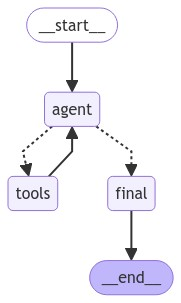

In [ ]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))


然後，我們可以從最終節點獲取串流輸出：

In [ ]:
inputs = {"messages": [("human", "請推薦一款傳統手搖飲")]}
async for chunk in app.astream(inputs, stream_mode="values"):
    #顯示最新訊息的內容，並且漂亮顯示出
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

請推薦一款傳統手搖飲
================================== Ai Message ==================================
Tool Calls:
  recommend_bubble_tea (call_sBFKwxoWFx1VAw9fsbnUOeaC)
 Call ID: call_sBFKwxoWFx1VAw9fsbnUOeaC
  Args:
    style: 傳統
================================= Tool Message =================================
Name: recommend_bubble_tea

你一定要品嚐一下台中第四信用合作社對面的珍珠奶茶，香濃滑順，珍珠有嚼勁！
================================== Ai Message ==================================

我推薦你品嚐台中第四信用合作社對面的珍珠奶茶，香濃滑順，珍珠有嚼勁！
================================== Ai Message ==================================

嘿嘿，我絕對要向大家推薦一下！別錯過台中第四信用合作社對面的珍珠奶茶喔！這杯奶茶香氣濃郁，口感滑順，還有那顆Q彈的珍珠，絕對讓你愛不釋手！快來一嚐，絕對不會讓你失望的！


結論
通過本教程，我們深入探討了 LangChain 和 LangGraph 的串流功能，從基本的 invoke 和 stream 方法，到更高級的事件串流和過濾技術。這些工具和技巧將幫助你構建更加靈活、高效的 AI 應用，提供卓越的用戶體驗。
關鍵takeaways：

串流技術對於提升 AI 應用的響應性至關重要
LangChain 和 LangGraph 提供了多種串流方法，適用於不同場景
事件串流 API 允許更細粒度的控制和監控
合理使用過濾技術可以優化串流事件的處理效率
選擇適當的串流模式（values 或 updates）可以根據需求獲取不同層面的信息